AC Bridge Analysis Notebook

{
  "sampRate": 48000,
  "freqHz": 100.0,
  "leftAmpl": 12000,
  "rightAmpl": 12000,
  "quietS": 4800,
  "exciteS": 9600,
  "numCyc": 20,
  "numPts": 1,
  "fName": "setUp",
  "phaseN": 0,
  "durationS": 28800
}
Omega: 0.01308997 rad/samp.
Measurement file "setUp-resp.wav" has 28800 samples.
M1: -4596.46920445-7975.47697999j
M2: -12662.21515808+7247.62925121j
Z1/Z2: 0.00187063+0.63093499j


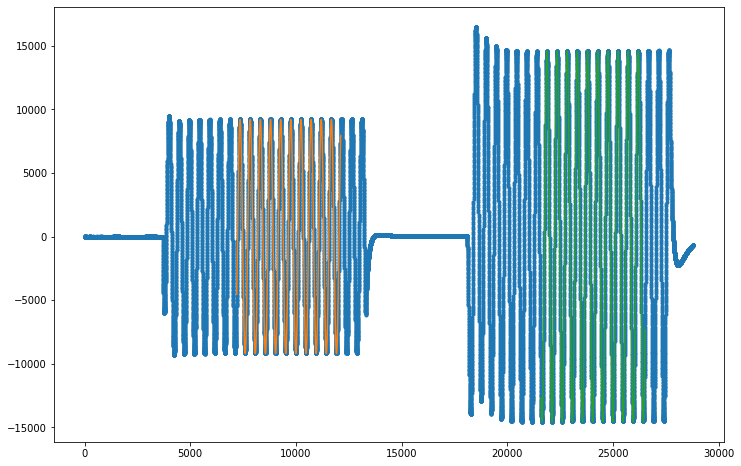

In [1]:
import wave, math, struct, os.path, json, cmath
import matplotlib.pyplot as plot, sys
%matplotlib inline
plot.rcParams['figure.figsize'] = [12, 8]

# initialize globals
mSeries = []                    # time series data from bridge detector
pTree = {}                      # measurement parameter tree

# set default values in parameter tree
pTree.update({
    'sampRate':  48000, # samples per second
    'freqHz':    100.0, # cycles per second
    'leftAmpl':  12000, # left channel amplitude
    'rightAmpl': 12000, # right channel amplitude
    'quietS':     4800, # quiet time in samples
    'exciteS':    9600, # excitation time in samples
    'numCyc':       20, # number of excitation cycles
    'numPts':        1, # measurements per iteration
    'fName':    'setUp' # name to use for disk files
})

# look for setup file, merge contents if found
if os.path.exists(pTree['fName'] + '.json'):
    with open(pTree['fName'] + '.json', 'r') as qFile:
        qTree = json.load(qFile)
        if qTree: pTree.update(qTree)
print (json.dumps(pTree, indent = 2))

# update omega in radians/sample
omega = 2.0 * math.pi * pTree['freqHz'] / pTree['sampRate']
print ('Omega: {0:.8f} rad/samp.'.format(omega))

# read measurement file into array
rName = pTree['fName'] + '-resp.wav'
if os.path.exists(rName):
    with wave.open(rName, 'rb') as mFile:
        (nchannels, sampwidth, framerate, nframes, comptype, compname) = mFile.getparams()
        while True:
            frame = mFile.readframes(1)
            if not len(frame): break
            sample = struct.unpack('<h', frame)
            mSeries.append(sample[0])
    print ('Measurement file "{0}" has {1} samples.'.format(rName, len(mSeries)))
else:
    print ('Measurement file "{0}" not found.'.format(rName))
    quit ()

# return dot product of two vectors
def dotPrdt(vec1, vec2):
    return sum([vec1[n] * vec2[n] for n in range(len(vec1))])

refCyc = int(pTree['numCyc'] / 2)
burstRange = pTree['exciteS'] * refCyc // pTree['numCyc']
refVec = [math.cos((n + 0.5) * omega) for n in range(burstRange)]
squareNorm = dotPrdt(refVec, refVec)
halfPi = pTree['exciteS'] // pTree['numCyc'] // 4
thePlot = thePlots = None
if (1 < pTree['numPts']): figure, thePlots = plot.subplots(pTree['numPts'])
else: figure, thePlot = plot.subplots()
startOffs = 0
for n in range(pTree['numPts']):
    # compute offsets into time series data
    beginI1 = startOffs + pTree['quietS'] + (pTree['exciteS'] // 4)
    endI1   = beginI1 + burstRange
    beginQ1 = beginI1 + halfPi
    endQ1   = endI1 + halfPi

    beginI2 = startOffs + (pTree['quietS'] * 2) + pTree['exciteS'] * 5 // 4
    endI2   = beginI2 + burstRange
    beginQ2 = beginI2 + halfPi
    endQ2   = endI2 + halfPi
    
    vectorI1 = mSeries[beginI1: endI1]
    vectorQ1 = mSeries[beginQ1: endQ1]
    vectorI2 = mSeries[beginI2: endI2]
    vectorQ2 = mSeries[beginQ2: endQ2]
    vectorM  = mSeries[startOffs: (startOffs + pTree['durationS'])]
    
    # compute in-phase and quadrature components for each burst
    dotPrdtI1 = dotPrdt(vectorI1, refVec)
    dotPrdtQ1 = dotPrdt(vectorQ1, refVec)
    dotPrdtI2 = dotPrdt(vectorI2, refVec)
    dotPrdtQ2 = dotPrdt(vectorQ2, refVec)
    
    # combine into complex values for each burst
    dotPrdt1 = (dotPrdtI1 - (1.0j * dotPrdtQ1)) / squareNorm
    dotPrdt2 = (dotPrdtI2 - (1.0j * dotPrdtQ2)) / squareNorm
        
    # plot measured response
    if (thePlot): thePlot.plot(list(range(0, pTree['durationS'])), vectorM, '.')
    else: thePlots[n].plot(list(range(0, pTree['durationS'])), vectorM, '.')

    # plot fitted response for first burst
    fitBurst1 = [(dotPrdt1 * cmath.exp(1.0j * (x + 0.5) * omega)).real for x in range(burstRange + halfPi)]
    if (thePlot): thePlot.plot(list(range(beginI1, endQ1)), fitBurst1, '-')
    else: thePlots[n].plot(list(range(beginI1-startOffs, endQ1-startOffs)), fitBurst1, '-')
    
    # plot fitted response for second burst
    fitBurst2 = [(dotPrdt2 * cmath.exp(1.0j * (x + 0.5) * omega)).real for x in range(burstRange + halfPi)]
    if (thePlot): thePlot.plot(list(range(beginI2, endQ2)), fitBurst2, '-')
    else: thePlots[n].plot(list(range(beginI2-startOffs, endQ2-startOffs)), fitBurst2, '-')

    # TODO account for different left and right excitation amplitudes
    # assume left and right excitations alternate
    print ('M1: {0:.8f}'.format(dotPrdt1))
    print ('M2: {0:.8f}'.format(dotPrdt2))
    print ('Z1/Z2: {0:.8f}'.format(dotPrdt1 * pTree['rightAmpl'] / dotPrdt2 / pTree['leftAmpl']))
    
    # next measurement
    startOffs += pTree['durationS']
    
# show all
# plot.show()
